


# Using DALL-E with CLIP to generate images from text 






# Choose Text

In [16]:
text_input = "a basket of fruits"


# pytorch and cuda compatbility

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

CUDA version: 10.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html


# imports


In [ ]:
# don't use half of these lol

import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output



# Perceptor

In [ ]:


%cd /content/

!git clone https://github.com/openai/CLIP.git


%cd /content/CLIP/

!pip install ftfy

import os
import clip
import torch

clip.available_models()

import numpy as np

# Load the model
perceptor, preprocess = clip.load('ViT-B/32', jit=True)
perceptor = perceptor.eval()

/content
fatal: destination path 'CLIP' already exists and is not an empty directory.
/content/CLIP


['RN50', 'ViT-B/32']

# Parameters

In [ ]:
# probably don't mess with this unless you're changing generator size
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape


# Define

In [ ]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')
  

# Generator

In [13]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

!pip install git+https://github.com/openai/DALL-E.git


from dall_e import map_pixels, unmap_pixels, load_model
target_image_size = sideX

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)


model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')


  Cloning https://github.com/openai/DALL-E.git to /tmp/pip-req-build-2mxi6t97
  Running command git clone -q https://github.com/openai/DALL-E.git /tmp/pip-req-build-2mxi6t97
  Created wheel for DALL-E: filename=DALL_E-0.1-cp37-none-any.whl size=6011 sha256=8cc32fe196ef9f387d0873c011ed04b18764f866ce51750778d4ff4a7872a134
  Stored in directory: /tmp/pip-ephem-wheel-cache-1vxkvn8z/wheels/e9/f5/e7/efa7ddb4c5899f6e6ffbbd112b8c7a030872274a5cba9ccf04
Successfully built DALL-E


# Latent coordinate

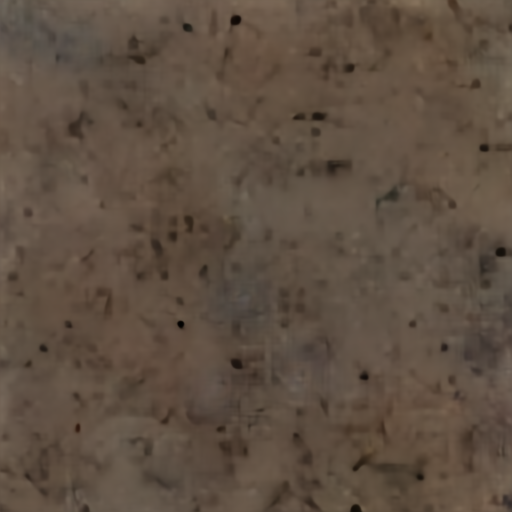

In [17]:

class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()

        self.normu = torch.nn.Parameter(torch.randn(1, 8192, 64, 64).cuda())



    def forward(self):

      normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1).view(1, 8192, 64, 64)

      return normu




lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{'params': mapper, 'lr': .1}])
eps = 0



tx = clip.tokenize(text_input)
t = perceptor.encode_text(tx.cuda()).detach().clone()


nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

with torch.no_grad():
  mult = 1
  al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
  for allls in al:
    displ(allls[:3])
    print('\n')
  # print(torch.topk(lats().view(1, 8192, -1), k=3, dim=-1))


# Train

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



  ##########################################################
   

[0, tensor([-1.9326], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 0


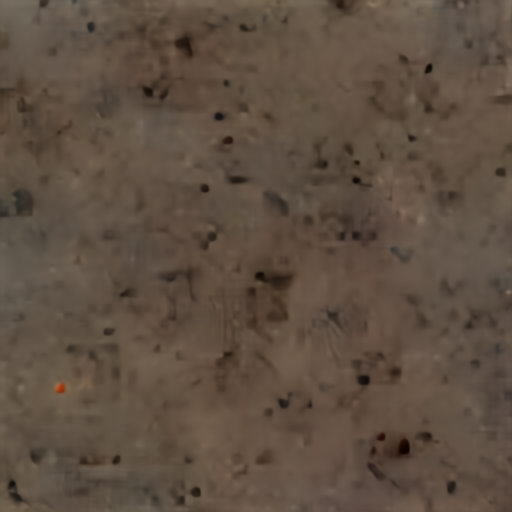




  ##########################################################
   

[0, tensor([-3.2441], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 100


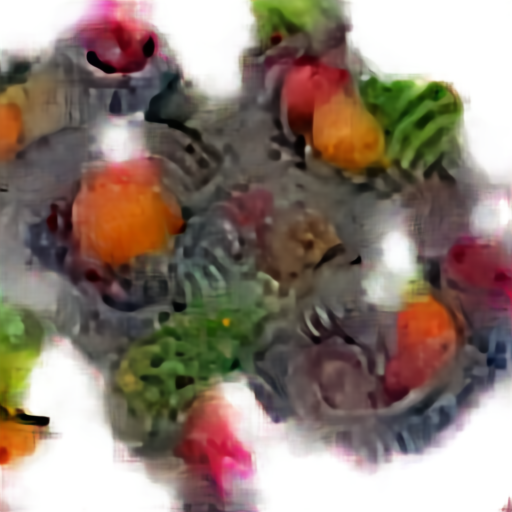




  ##########################################################
   

[0, tensor([-3.7031], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 200


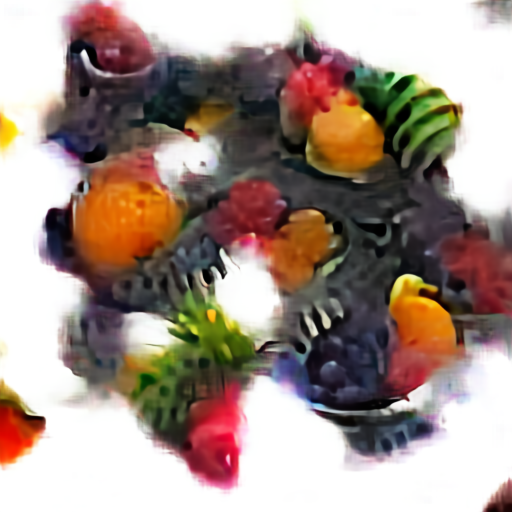




  ##########################################################
   

[0, tensor([-4.0859], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 300


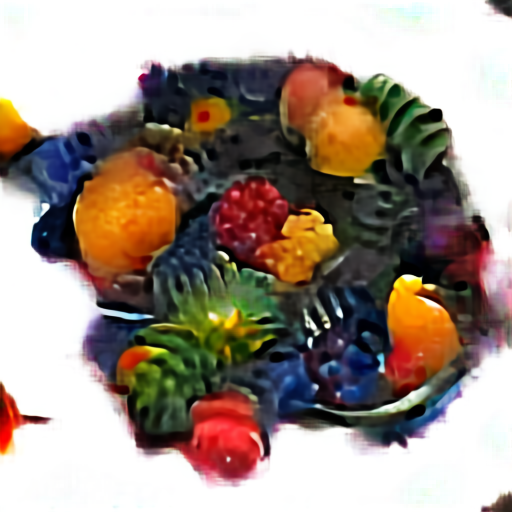




  ##########################################################
   

[0, tensor([-4.2891], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 400


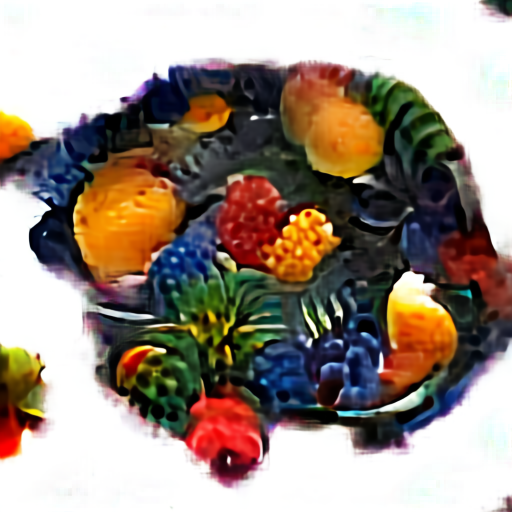




  ##########################################################
   

[0, tensor([-4.4141], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 500


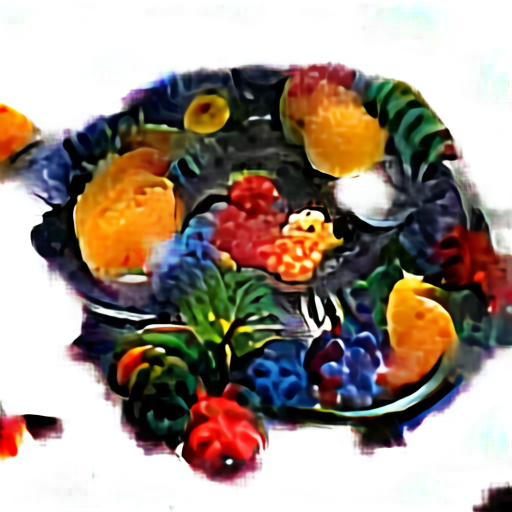




  ##########################################################
   

[0, tensor([-4.3125], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 600


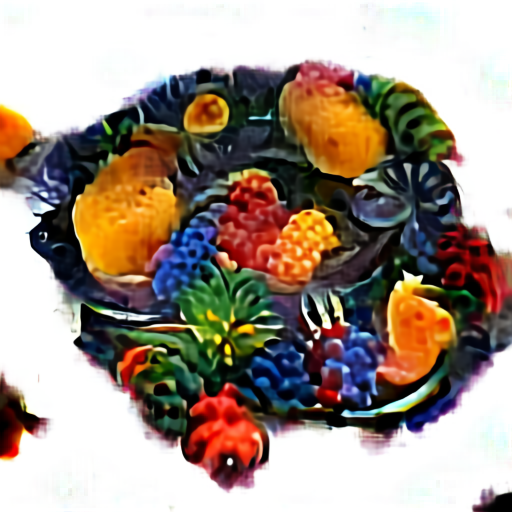




  ##########################################################
   

[0, tensor([-4.6953], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 700


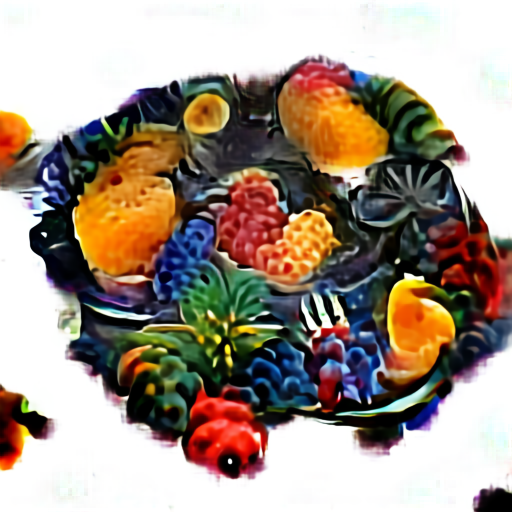




  ##########################################################
   

[0, tensor([-4.7109], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 800


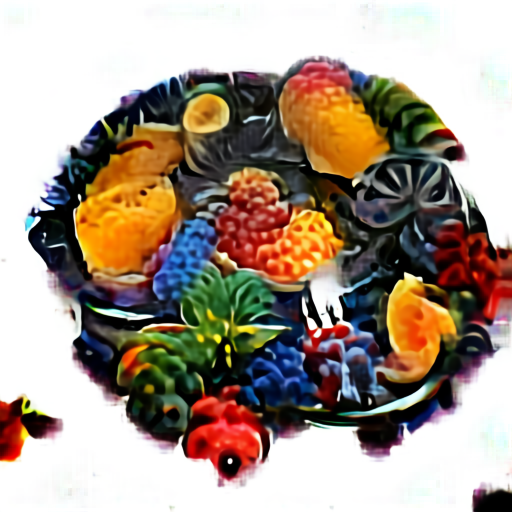




  ##########################################################
   

[0, tensor([-4.8516], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 900


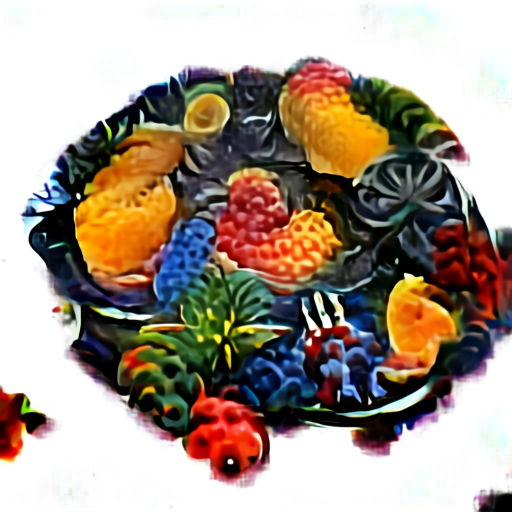




  ##########################################################
   

[0, tensor([-4.9375], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 1000


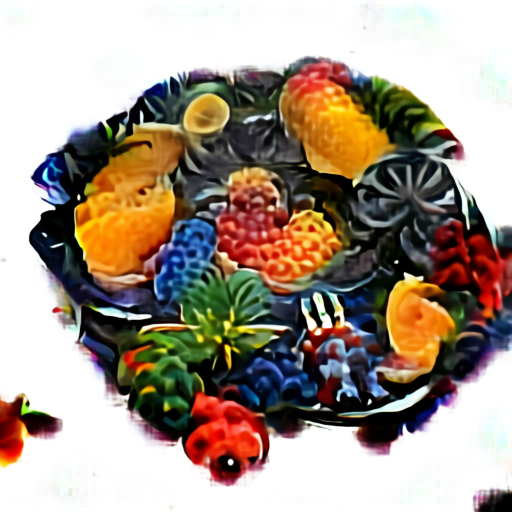




  ##########################################################
   

[0, tensor([-4.8164], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 1100


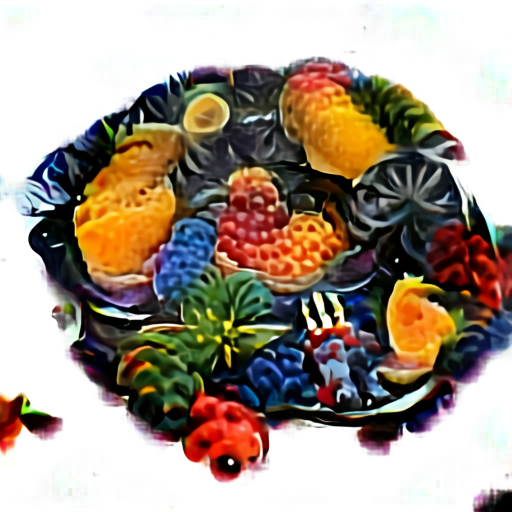




  ##########################################################
   

[0, tensor([-5.0430], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 1200


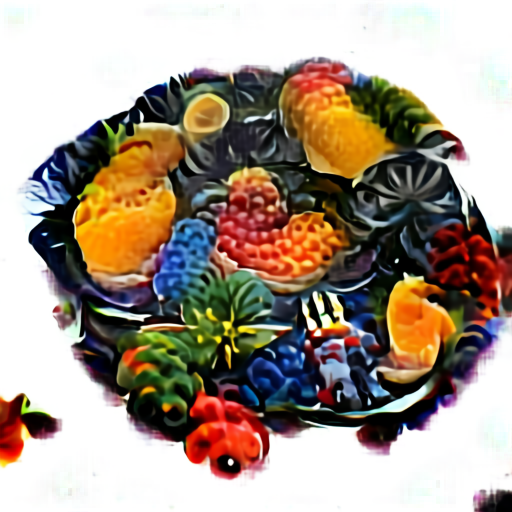




  ##########################################################
   

[0, tensor([-4.9922], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 1300


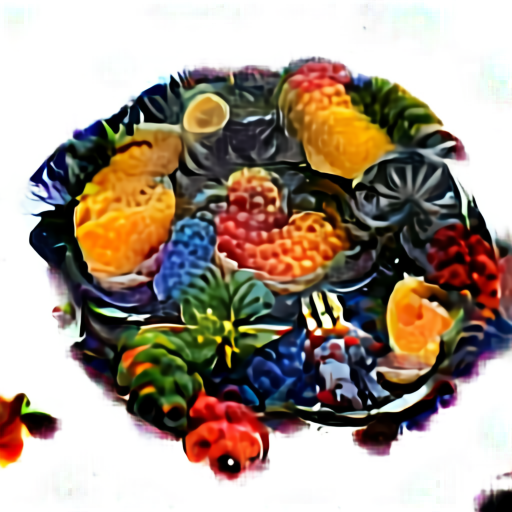

KeyboardInterrupt: ignored

In [18]:

def checkin(loss):
  print('''
  ##########################################################
  ''',
        loss, '\n',itt)
  
  with torch.no_grad():
    al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')
  # the people spoke and they love "ding"
  output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')


def ascend_txt():
  out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))

  cutn = 64 # improves quality
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .98))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  # into = torch.nn.functional.interpolate(out, (224,224), mode='nearest')

  into = nom(into)

  iii = perceptor.encode_image(into)


  llls = lats()
  lat_l = 0



  return [lat_l, 10*-torch.cosine_similarity(t, iii).view(-1, 1).T.mean(1)]

def train(i):
  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1]
  loss = loss.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  

  
  
  if itt % 100 == 0:
    checkin(loss1)


itt = 0
for asatreat in range(10000):
  train(itt)
  itt+=1

